# Introduction

The main idea is to analyze the passes in & out the area.

The first step is to find wich passes are in & out, because in the data there are only coordintes of where the players where located

# Libraries

In [1]:
#!pip install mplsoccer
import pandas as pd
import numpy as np
import seaborn as sns
from kloppy.domain import PitchDimensions
import kloppy
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import json
import dask.dataframe as dd
from mplsoccer.pitch import Pitch
from sklearn.neighbors import NearestNeighbors

C:\Users\const\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Read Data

Read data from Oakland UCL 2023

In [2]:
df_2023 = pd.read_csv('USLChampionship_2023.csv')
df_2022 = pd.read_csv('USLChampionship_2022.csv')
df_2021 = pd.read_csv('USLChampionship_2021.csv')

C:\Users\const\AppData\Local\Temp\ipykernel_21344\1398877321.py:1: DtypeWarning: Columns (0,1,4,5,7,8,9,10,11,13,15,19,20,21,22,23,24,29,34,39,49,51,52,53,54,55,56,57,58,60,61,63,66,67,68,69,70,71,82,85,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023 = pd.read_csv('USLChampionship_2023.csv')
C:\Users\const\AppData\Local\Temp\ipykernel_21344\1398877321.py:2: DtypeWarning: Columns (0,1,3,4,6,7,8,9,10,12,14,18,19,20,22,23,24,25,26,27,28,29,32,50,52,54,57,64,78,79,80,81,82,86,87,88,92,93,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('USLChampionship_2022.csv')
C:\Users\const\AppData\Local\Temp\ipykernel_21344\1398877321.py:3: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,11,13,14,15,1

In [3]:
df_2023 ['season'] = 2023
df_2022 ['season'] = 2022
df_2021 ['season'] = 2021

In [4]:
data = pd.concat([df_2023, df_2022, df_2021]).reset_index(drop = True)

In [5]:
del(df_2023)
del(df_2022)
del(df_2021)

In [6]:
len(data)

4605211

In [7]:
def coord_x(arr):
    if arr is not None and len(arr) > 0:
        return arr[0]
    else:
        return None

In [8]:
def coord_y(arr):
    if arr is not None and len(arr) > 0:
        return arr[1]
    else:
        return None

In [9]:
def preprocess(df):
    df = df[~df.location.isnull()]
    df = df[~df.pass_end_location.isnull()]
    df[['location_x' , 'location_y']] = pd.DataFrame(df['location'].apply(lambda x: json.loads(x.replace("'", "\""))).tolist())
    df[['location_x_destiny' , 'location_y_destiny']] = pd.DataFrame(df['pass_end_location'].apply(lambda x: json.loads(x.replace("'", "\""))).tolist())
    df['big_area_origin'] = np.where(df.location_x is None, 0,
                            np.where(((df.location_x<=20) & (df.location_x>=0) & (df.location_y >= 20) & (df.location_y<=60)) |
                                     ((df.location_x<=120) & (df.location_x>=100) & (df.location_y >= 20) & (df.location_y<=60)),1,0))
    df['big_area_destiny'] = np.where(df.location_x_destiny is None, 0,
                            np.where(((df.location_x_destiny<=20) & (df.location_x_destiny>=0) & (df.location_y_destiny >= 20) & (df.location_y_destiny<=60)) |
                                     ((df.location_x_destiny<=120) & (df.location_x_destiny>=100) & (df.location_y_destiny >= 20) & (df.location_y_destiny<=60)),1,0))
    matches = df[['match_id', 'team']].drop_duplicates()
    passes = df[df['type'] == 'Pass'].dropna(axis = 1, how = 'all')
    passes = passes[(passes['pass_type'].isin(['Recovery', 'Interception'])) | (passes['pass_type'].isnull())].reset_index(drop = True)
    passes = passes.merge(matches, on='match_id', suffixes=('', '_opp'), how='left')
    passes = passes[passes['team'] != passes['team_opp']].reset_index(drop = True)
    passes.rename(columns={'team_opp': 'opp_team'}, inplace=True)
    passes['pass_outcome'] = passes['pass_outcome'].fillna('Complete')
    #passes = passes[(passes['location_x'] >= 60) & (passes['location_y'] >= 18) & (passes['location_y'] <= 62 ) & (passes['location_y_destiny'] >= 18) & (passes['location_y_destiny'] <= 62 ) & (passes['location_x_destiny'] >= 102)]
    return passes

In [10]:
data = preprocess(data)

In [11]:
len(data)

1139349

In [12]:
data.columns

Index(['counterpress', 'duration', 'id', 'index', 'location', 'match_id',
       'minute', 'obv_against_after', 'obv_against_before', 'obv_against_net',
       'obv_for_after', 'obv_for_before', 'obv_for_net', 'obv_total_net',
       'off_camera', 'out', 'pass_aerial_won', 'pass_angle',
       'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_deflected', 'pass_end_location',
       'pass_goal_assist', 'pass_height', 'pass_length', 'pass_outcome',
       'pass_outswinging', 'pass_pass_cluster_id', 'pass_pass_cluster_label',
       'pass_pass_cluster_probability', 'pass_pass_success_probability',
       'pass_recipient', 'pass_shot_assist', 'pass_switch', 'pass_technique',
       'pass_through_ball', 'pass_type', 'period', 'play_pattern', 'player',
       'player_id', 'position', 'possession', 'possession_team',
       'possession_team_id', 'related_events', 'second', 'team', 'team_id',
       'timestamp', 'type', 'under_pressure', 'pass_inswinging',


In [13]:
data['location_x'] = data['location_x'].astype(float).replace(120, 119.999)
data['location_y'] = data['location_y'].astype(float).replace(80, 79.999)
data['location_x_destiny'] = data['location_x_destiny'].astype(float).replace(120, 119.999)
data['location_y_destiny'] = data['location_y_destiny'].astype(float).replace(80, 79.999)

In [14]:
data = data[data['location_x']>=0]
data = data[data['location_x']<=120]

data = data[data['location_y']>=0]
data = data[data['location_y']<=80]

data = data[data['location_x_destiny']>=0]
data = data[data['location_x_destiny']<=120]

data = data[data['location_y_destiny']>=0]
data = data[data['location_y_destiny']<=80]

In [15]:
len(data)

316099

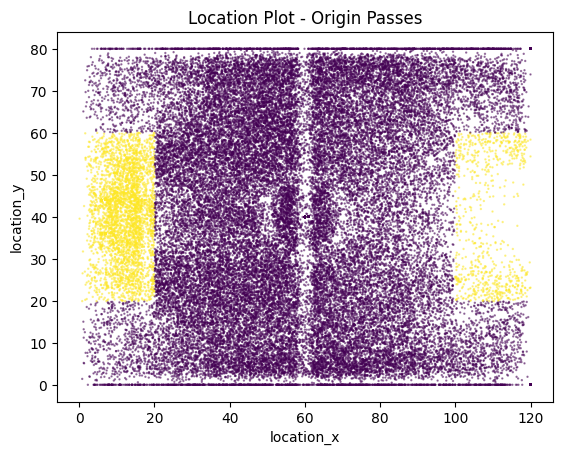

In [16]:
plt.scatter(data['location_x'].head(50000), data['location_y'].head(50000), alpha = 0.5, c = data['big_area_origin'].head(50000), s = 0.5)

# Add labels and title
plt.xlabel('location_x')
plt.ylabel('location_y')
plt.title('Location Plot - Origin Passes')

# Show the plot
plt.show()

# Court Function

In [17]:
def plot_soccer_court():
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Set the figure size and axis limits
    fig.set_size_inches(7, 5)
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 80)

    # Plot the outer boundary of the soccer court
    ax.plot([0, 120, 120, 0, 0], [0, 0, 80, 80, 0], color='black')
    
    # Center line
    ax.plot([60, 60], [0, 80], color='black')
    
    # Middle circle
    ax.add_patch(plt.Circle((60, 40), 9, color='black', fill=False))
    
    # Penalty areas
    ax.plot([0, 20], [20, 20], color='black')
    ax.plot([0, 20], [60, 60], color='black')
    ax.plot([20, 20], [20, 60], color='black')
    
    ax.plot([100, 120], [20, 20], color='black')
    ax.plot([100, 120], [60, 60], color='black')
    ax.plot([100, 100], [20, 60], color='black')
     
    
    # Set the aspect ratio to equal
    ax.set_aspect('equal')

    # Remove the axis labels and ticks
    ax.axis('off')

# Pass Clustering

For this project, we will focus only in passes from out to inside the box.

So, the idea is to filter first only these kind of passes.

The clusters will be divided in:
 - Ground & Low
 - High

So, will be needed to fit 2 clustering algorigthms.

The steps for this will be:

 - Create a function to clean the data, and keep only passes from outside to inside the box, and the type of passes needed.
 - Create to function to fit a k-means, with the viz of the elbow plot, and the number of clusters.

The clusters will be viz with the centroid of each cluster.

The centroid will be defined as the average of the x & y coords for origin and destiny for each group.


## Clean data function

In [18]:
def clean_data(df,pass_type): # pass types can be 'high' or 'low'. And low will include ground
    
    # Keep passes with known place
    df = df[df.location_x.notnull()]
    
    # Keep passes only from outside to inside the box
    df = df[((df.location_x_destiny<=120) & (df.location_x_destiny>=100) & (df.location_y_destiny >= 20) & (df.location_y_destiny<=60))]
    df = df[~((df.location_x<=120) & (df.location_x>=100) & (df.location_y >= 20) & (df.location_y<=60))]
    
    # Keep only the type of passes requiered
    pt = np.where(pass_type == 'high', ['High Pass'], ['Low Pass','Ground Pass'])
    df = df[df.pass_height.isin(pt)]
    
    return df

## Cluster viz function

Function to viz clusters and elbow for a pass type

In [19]:
def cluster_viz(df,k_num,pass_type):
    
    # Get data for the clustering
    dataC = clean_data(df,pass_type)
    
    dataC_features = dataC[clusterFeatures_num]
    dataC_features = dataC_features.dropna()
    
    # Scale features
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(dataC_features)
    
    # elbow
    inertia = []
    for k in range(2, 30):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(df_scaled)
        inertia.append(kmeans.inertia_)
    
    plt.plot(range(2, 30), inertia)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method - Low Passes')
    plt.show()
    
    # Defined number of clusters
    kmeans = KMeans(n_clusters=k_num, random_state=0)
    kmeans.fit(df_scaled)
    
    # Add clusters to the data
    dataC_features['cluster'] = kmeans.labels_
    
    # Viz centroid clusters
    plot_soccer_court()
    for i in range(dataC_features.cluster.max()):
        aux = dataC_features[dataC_features.cluster == i]
        plt.plot([aux.location_x.mean(), aux.location_x_destiny.mean()],
                 [aux.location_y.mean(), aux.location_y_destiny.mean()], i)

    for i in range(dataC_features.cluster.max()):
        aux = dataC_features[dataC_features.cluster == i]
        plt.text(aux.location_x.mean(),aux.location_y.mean(), i)

    titleName = np.where(pass_type == 'high', 'High', ['Low & Ground'])[0]
    
    plt.title(titleName + ' Passes Clusters - KMeans')
    

## Cluster Plot Function

In [20]:
def plot_cluster(df, tb_df,selected_cluster, sample, ind_pass, payoff = False):
    passes = df[(df['cluster'] == selected_cluster)]
    sample = passes.sample(n=sample)
    pitch = plot_soccer_court()
    #fig, ax = pitch.draw(figsize=(8, 5))
    #fig.set_facecolor('w')
    for i in range(len(sample)):
        plt.plot([sample.location_x, sample.location_x_destiny],
                 [sample.location_y, sample.location_y_destiny], i, color = 'b')
    if payoff:
      xPayoff = np.round(tb_df[tb_df['cluster'] == selected_cluster]['payoff'].values[0], 4)
      plt.title(f'Cluster {selected_cluster} {ind_pass} passes - xPayoff {xPayoff}', color = 'k')
    else:
      plt.title(f'Cluster {selected_cluster} {ind_pass} passes', color = 'k')

## Features for clustering

In [21]:
# Define features for the clustering
#clusterFeatures_num = ['pass_angle','pass_length','pass_pass_cluster_probability',
#                           'pass_pass_success_probability','location_x','location_y',
#                           'location_x_destiny','location_y_destiny']

# Define features for the clustering
clusterFeatures_num = ['location_x','location_y',
                       'location_x_destiny','location_y_destiny',
                       'pass_angle','pass_length']

### High

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


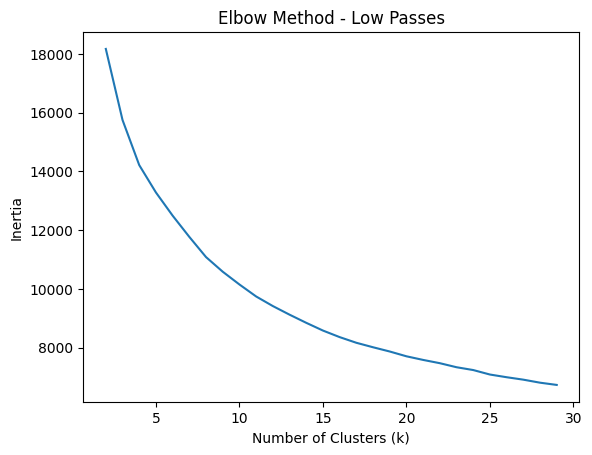

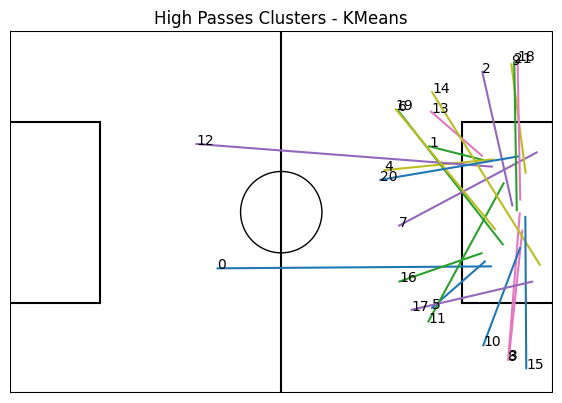

In [22]:
cluster_viz(data,23,'high')

### Low

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


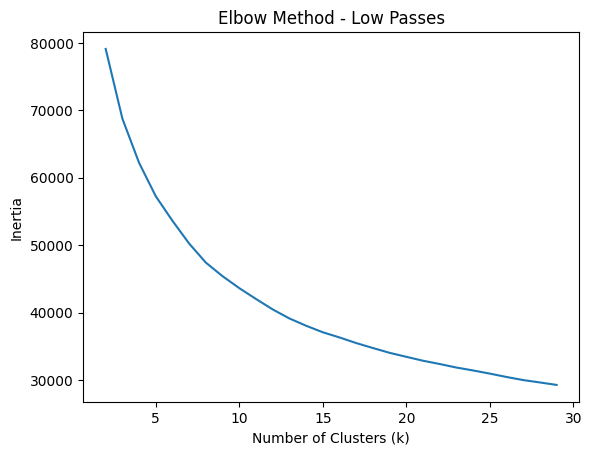

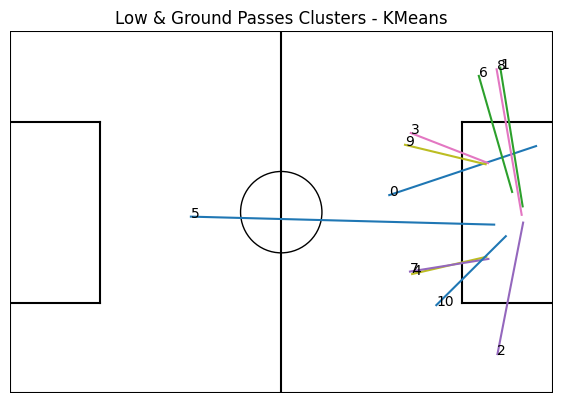

In [23]:
cluster_viz(data,12,'low')

## Cluster data frame function

Function to add the cluster label to a data frame for a certain pass type.

With the past function we can viz the clusters and the decide the optimal

In [24]:
def cluster_label(df,k_num,pass_type):
    
    # Get data for the clustering
    dataC = clean_data(df,pass_type)
    dataC = dataC.reset_index()
    dataC = dataC.drop(columns = 'level_0')
    
    dataC_features = dataC[clusterFeatures_num]
    dataC_features = dataC_features.dropna()
    
    # Scale features
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(dataC_features)
    
    # Defined number of clusters
    kmeans = KMeans(n_clusters=k_num, random_state=0)
    kmeans.fit(df_scaled)
    
    # Add clusters to the data cleaned
    dataC_features['cluster'] = kmeans.labels_
    
    # Add cluster to the whole data if matches, if not, will be cluster -1
    data_final = dataC
    data_final = data_final.merge(dataC_features, on = clusterFeatures_num, how = 'left')
    data_final['cluster'] = np.where(data_final.cluster.isnull(),-1, data_final.cluster)
    
    return data_final, kmeans, scaler
    

In [25]:
data_high, kmeans_high, scaler_high = cluster_label(data,25,'high')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [26]:
data_low, kmeans_low, scaler_low = cluster_label(data,25,'low')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


# xTreaths

In [27]:
xT = pd.read_csv('USL_xT_model.csv')

def get_start_xT_values(row):
    return xT.iloc[row['y_bin'] - 1, row['x_bin'] - 1]

def get_end_xT_values(row):
    return xT.iloc[row['end_y_bin'] - 1, row['end_x_bin'] - 1]

x_edges = np.array([  0., 6., 12., 18., 25., 32., 39., 46.,
                   53., 60., 67., 74.,  81., 88., 95., 102.,
                   108., 114., 120.])

y_edges = np.array([ 0., 6., 12., 18., 24., 30., 35., 40., 45., 50., 56.,
                   62., 68., 74., 80.])

ddf = dd.from_pandas(data, npartitions=10)
ddf = dd.from_pandas(data, npartitions=10)
ddf['x_bin'] = ddf['location_x'].apply(np.digitize, bins=x_edges)
ddf['y_bin'] = ddf['location_y'].apply(np.digitize, bins=y_edges)
ddf['end_x_bin'] = ddf['location_x_destiny'].apply(np.digitize, bins=x_edges)
ddf['end_y_bin'] = ddf['location_y_destiny'].apply(np.digitize, bins=y_edges)

# Check apply function for multiple rows
ddf['start_xT'] = ddf.apply(get_start_xT_values, axis = 1)
ddf['end_xT'] = ddf.apply(get_end_xT_values, axis = 1)

data = ddf.compute()
data['end_xT'] = np.where(data['pass_outcome'] == 'Complete', data['end_xT'], 0)
data['xT_net'] = data['end_xT'] - data['start_xT']
data['pass_outcome_num'] = data['pass_outcome'].apply(lambda x: 1 if x == 'Complete' else 0)
data.head()

counterpress  duration                                    id  index  \
0         <NA>  3.385992  b39105cb-94f2-42d1-9271-6a45f47e1a32      7   
1         <NA>  1.023627  71da57d8-68a8-498e-8816-ef40bab7c6c9      9   
2         <NA>  0.861978  2614a0ab-cd9a-4694-a205-1e913df49a65     11   
3         <NA>  0.588786  b989f70f-97e9-4c9c-a109-e7077395d493     13   
4         <NA>  1.189467  591d043c-ae12-4a60-b6f9-fd7006f6c65f     15   

       location  match_id  minute  obv_against_after  obv_against_before  \
0  [40.8, 45.7]   3878946       0           0.007295            0.010712   
1  [30.2, 56.9]   3878946       0           0.022493            0.015047   
2  [74.1, 22.4]   3878946       0           0.014684            0.007295   
3  [39.0, 51.4]   3878946       0           0.010596            0.022493   
4  [43.6, 57.2]   3878946       0           0.024713            0.010596   

   obv_against_net  ...  big_area_destiny                opp_team  x_bin  \
0        -0.003417  ...                 0  Pittsburgh Riverhounds     11   
1         0.007446  ...                 0       Tampa Bay Rowdies     12   
2         0.007389  ...                 0  Pittsburgh Riverhounds     13   
3        -0.011896  ...                 0       Tampa Bay Rowdies      5   
4         0.014117  ...                 0       Tampa Bay Rowdies      7   

   y_bin end_x_bin end_y_bin  start_xT    end_xT    xT_net pass_outcome_num  
0      2        12         3  0.007320  0.000000 -0.007320                0  
1      3        13         1  0.011501  0.000000 -0.011501                0  
2      1        14         4  0.014000  0.000000 -0.014000                0  
3     11        12        13  0.001964  0.011318  0.009354                1  
4      2        11         4  0.002657  0.000000 -0.002657                0  

[5 rows x 74 columns]

### Pay Off

Add PayOff to the data

In [28]:
def get_payoff(row):
    if row['pass_outcome'] != 'Complete':
      return -row['start_xT']
    else:
      return row['xT_net']

data['payoff'] = data.apply(get_payoff, axis = 1)

## Add xT & PayOff to the High and Low data

Once xT had been calculated, add the **xT_net** and **pass_outcome_num** values to **high** and **low** passes

In [29]:
data_high = data_high.merge(data[['xT_net','pass_outcome_num', 'payoff']+clusterFeatures_num], on = clusterFeatures_num, how = 'left')

In [30]:
data_low  = data_low.merge(data[['xT_net','pass_outcome_num', 'payoff']+clusterFeatures_num], on = clusterFeatures_num, how = 'left')

### Best clusters

Get best 5 clusters for each pass types

In [31]:
tb_agg_high = data_high.groupby('cluster')['payoff'].mean().sort_values(ascending=False).reset_index().head(5)
tb_agg_low  = data_low.groupby('cluster')['payoff'].mean().sort_values(ascending=False).reset_index().head(5)

### Plot best clusters 

#### High

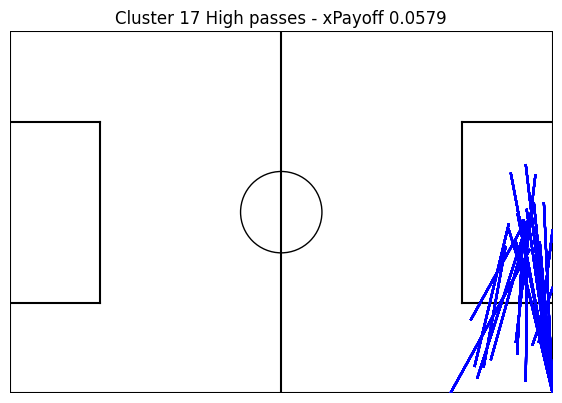

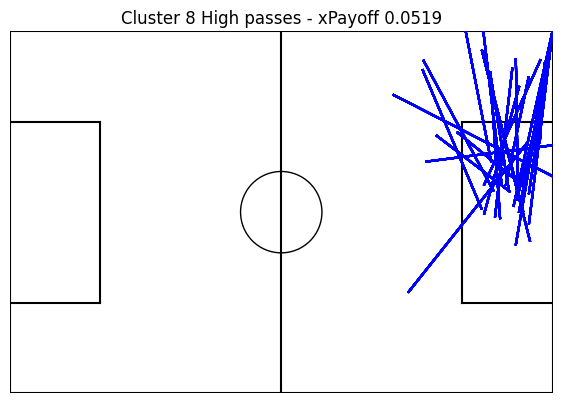

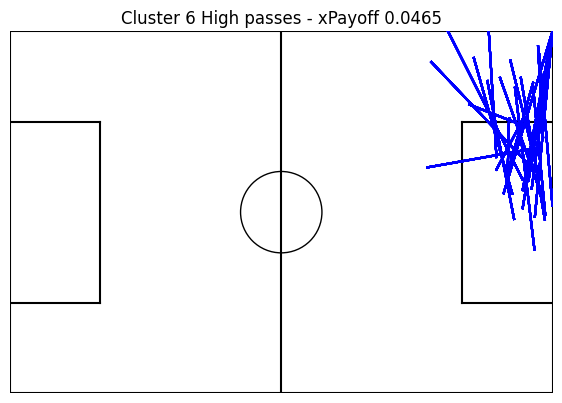

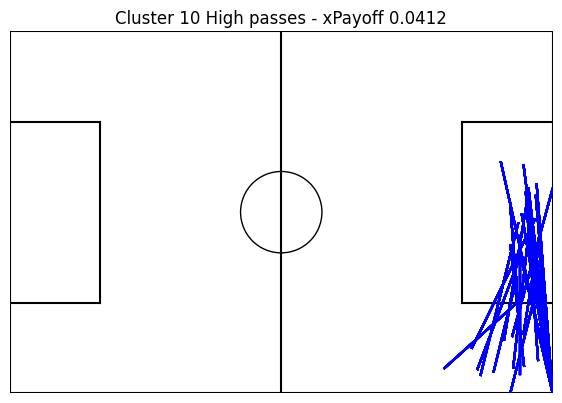

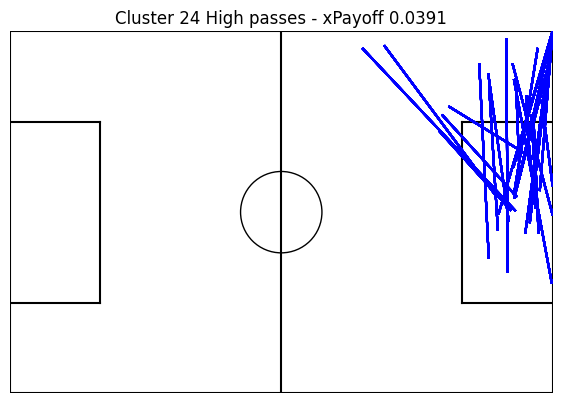

In [32]:
for cluster in tb_agg_high['cluster']:
    plot_cluster(data_high, tb_agg_high, cluster, 25, 'High', payoff = True)

#### Low & Ground

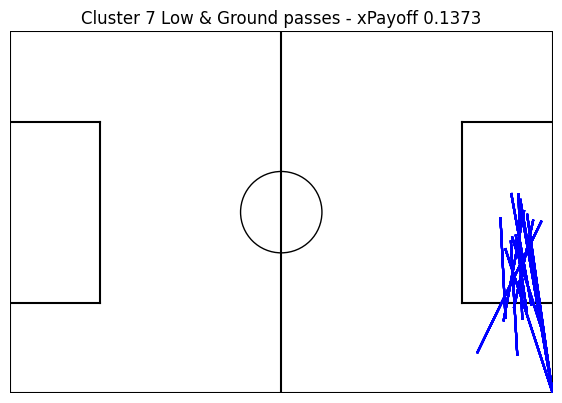

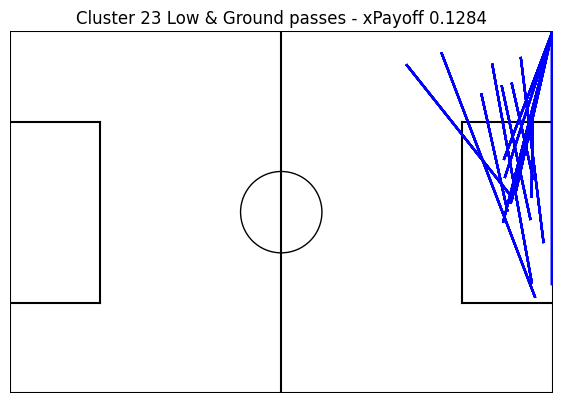

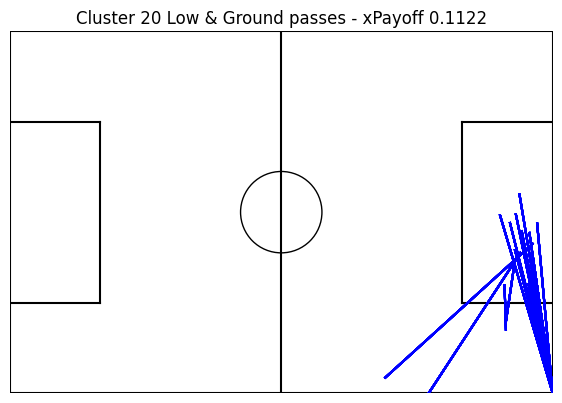

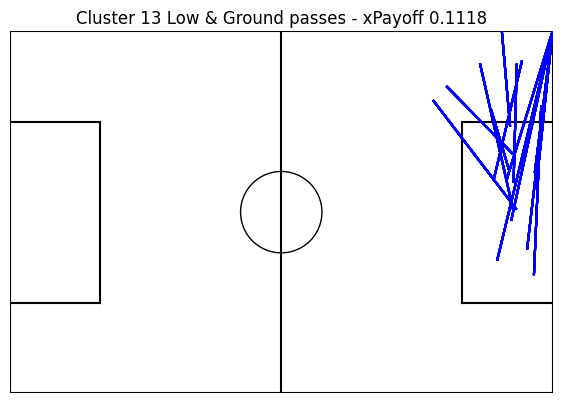

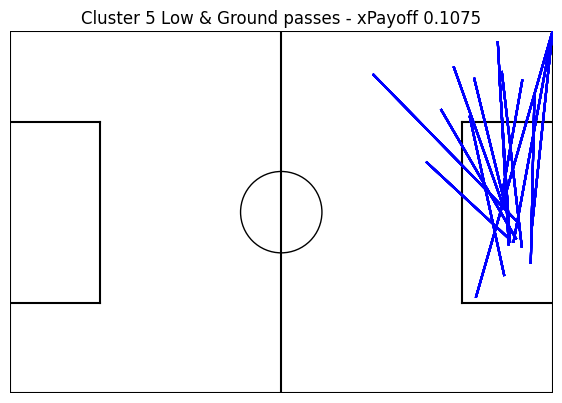

In [33]:
for cluster in tb_agg_low['cluster']:
    plot_cluster(data_low, tb_agg_low, cluster, 14, 'Low & Ground', payoff = True)

### Plot worst clusters

In [34]:
tb_agg_high_w = data_high.groupby('cluster')['payoff'].mean().sort_values(ascending=False).reset_index().tail(5)
tb_agg_low_w  = data_low.groupby('cluster')['payoff'].mean().sort_values(ascending=False).reset_index().tail(5)

#### High

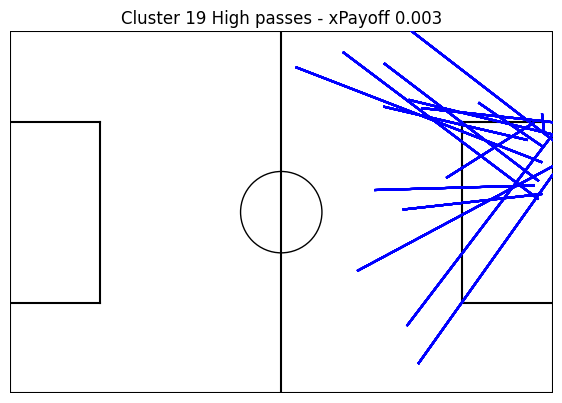

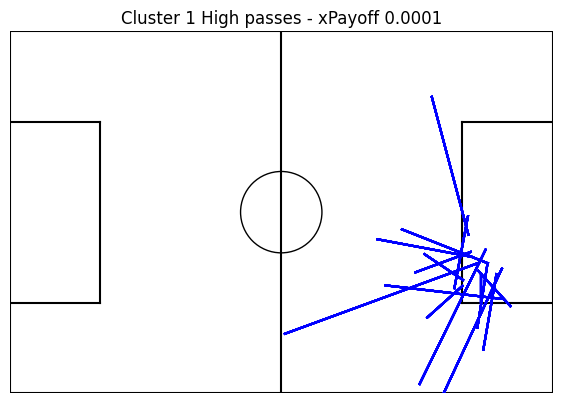

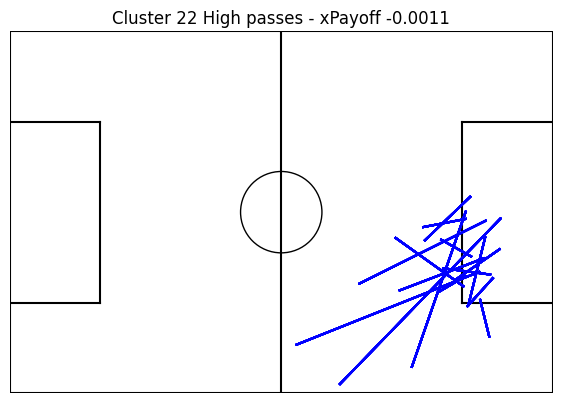

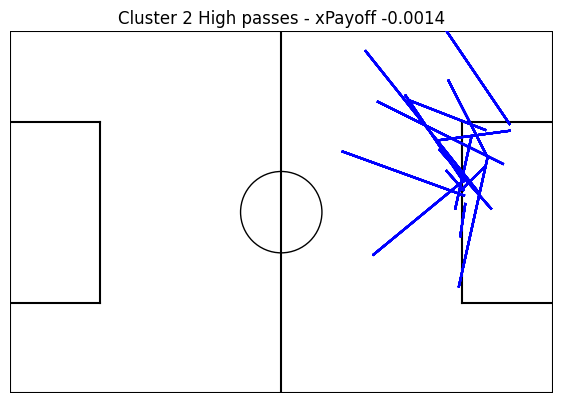

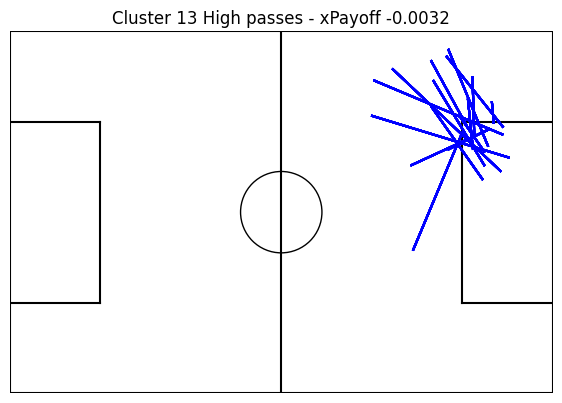

In [35]:
for cluster in tb_agg_high_w['cluster']:
    plot_cluster(data_high, tb_agg_high_w, cluster, 15, 'High',payoff = True)

#### Low & Ground

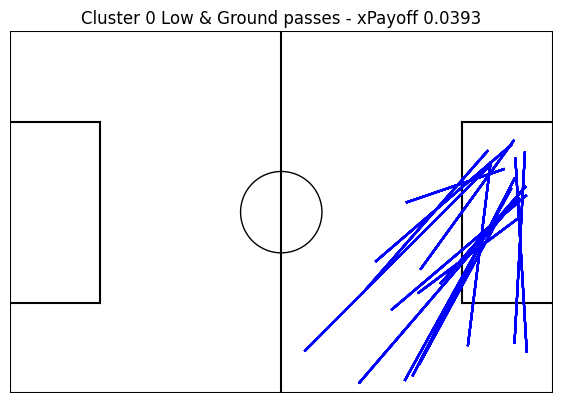

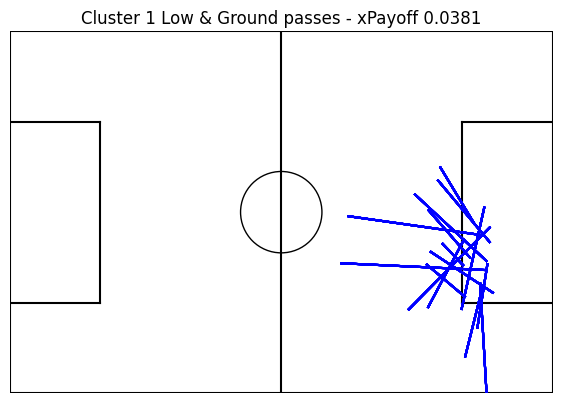

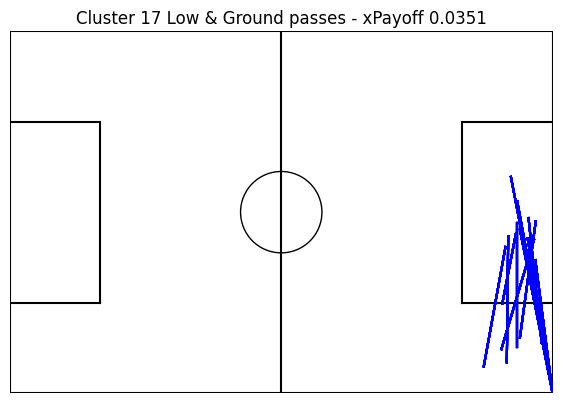

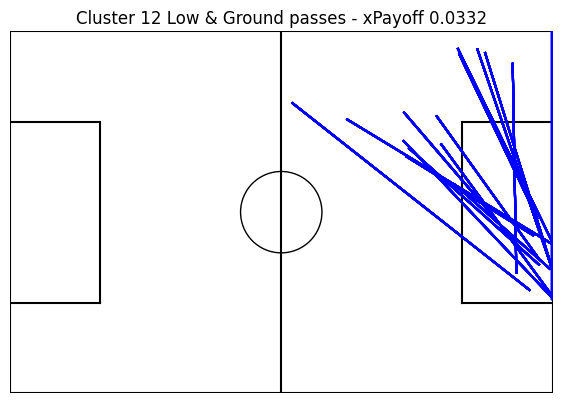

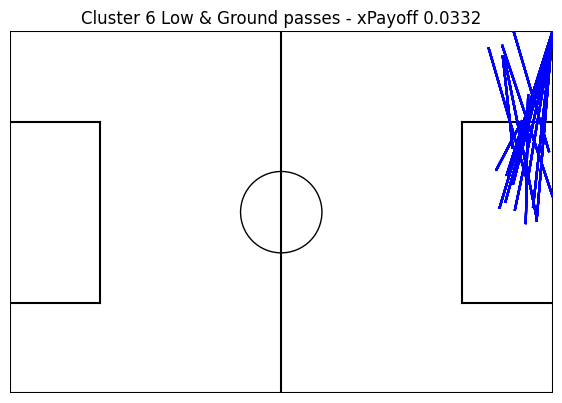

In [36]:
for cluster in tb_agg_low_w['cluster']:
    plot_cluster(data_high, tb_agg_low_w, cluster, 15, 'Low & Ground', payoff = True)

### Areas clustered - Dangerous

Top 3 clusters for High & Low passes

In [37]:
def area_clustered(df,df_agg,top_clust,ind_pass):
    best = df_agg['cluster'][top_clust-1]
    best_cluster = df[df['cluster'] == best]
    pitch = Pitch(pitch_type='statsbomb',pitch_color='w', line_color='k')
    fig, ax = pitch.draw(figsize=(8, 6))
    fig.set_facecolor('w')
    hull = pitch.convexhull(best_cluster['location_x'], best_cluster['location_y'])
    poly = pitch.polygon(hull, ax=ax, edgecolor='cornflowerblue', facecolor='cornflowerblue', alpha=0.3)
    scatter = pitch.scatter(best_cluster['location_x'], best_cluster['location_y'], ax=ax, edgecolor='black', facecolor='cornflowerblue', s = 20)
    plt.title(ind_pass+' passes Area Viz - cluster: '+str(best))
    plt.show()

### High Passes

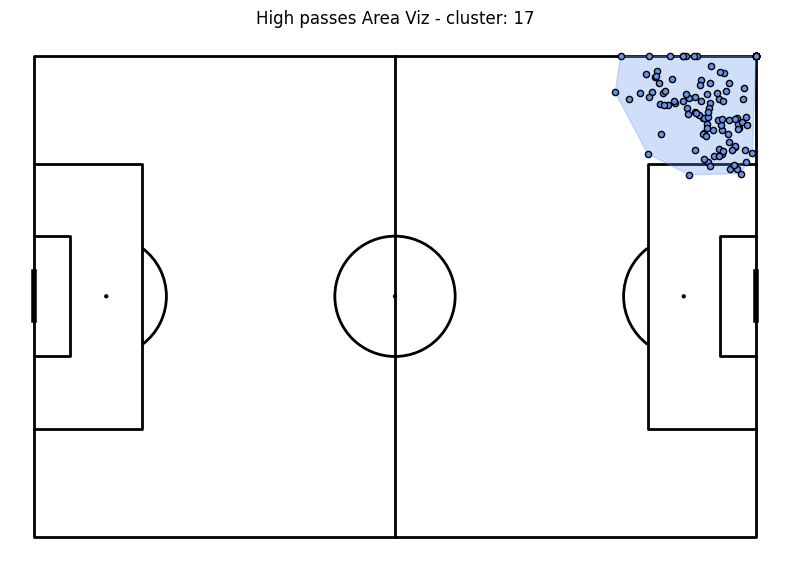

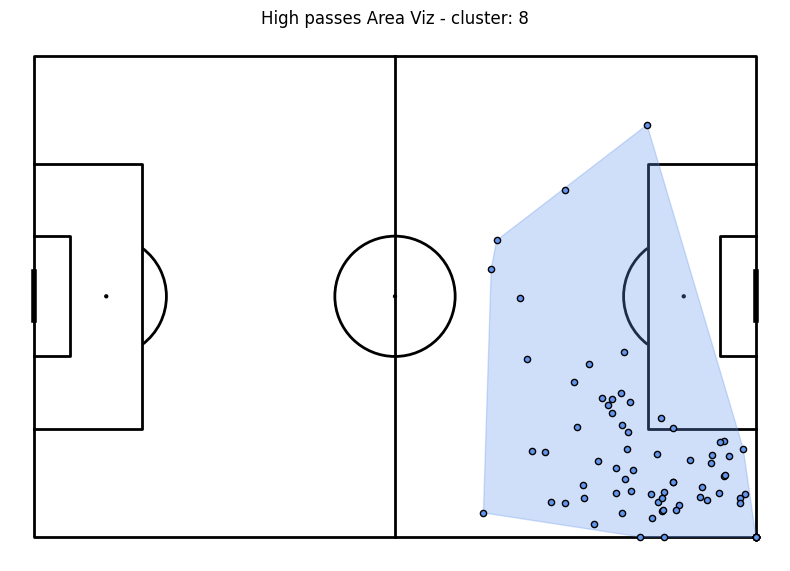

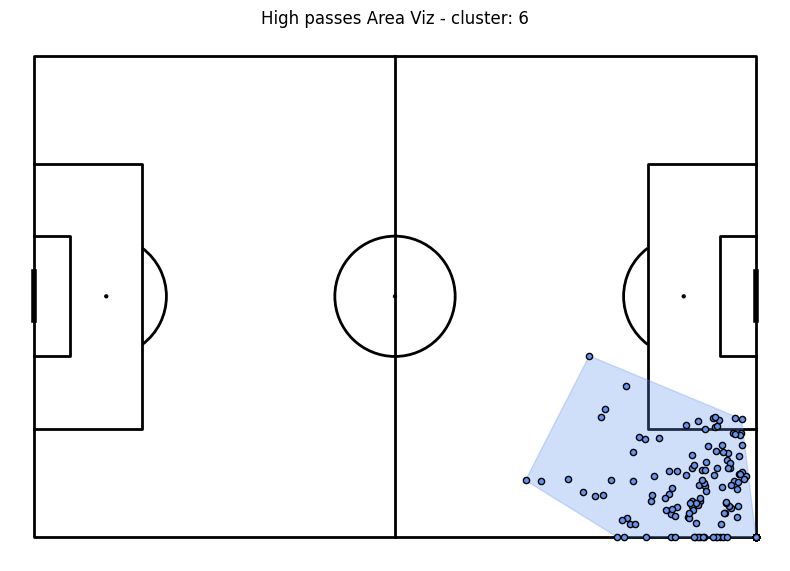

In [38]:
for cluster in range(1,4):
    area_clustered(data_high,tb_agg_high,cluster,'High')

### Low Passes

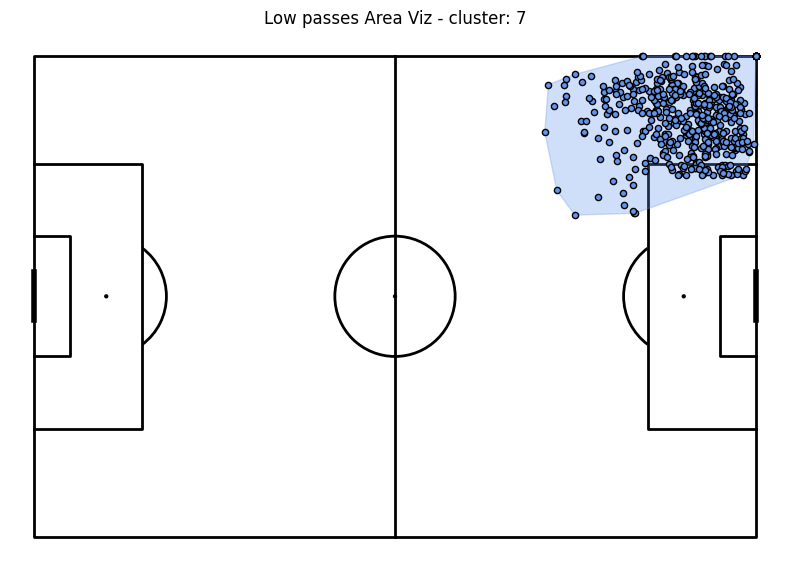

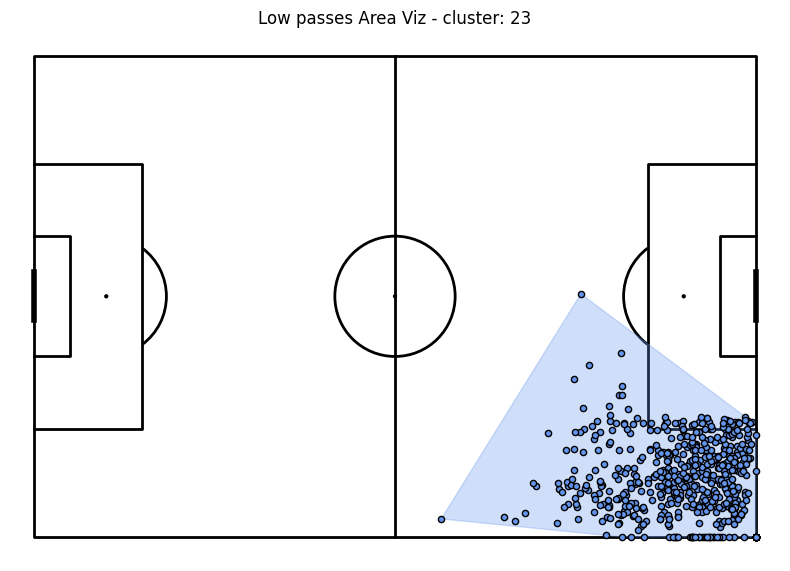

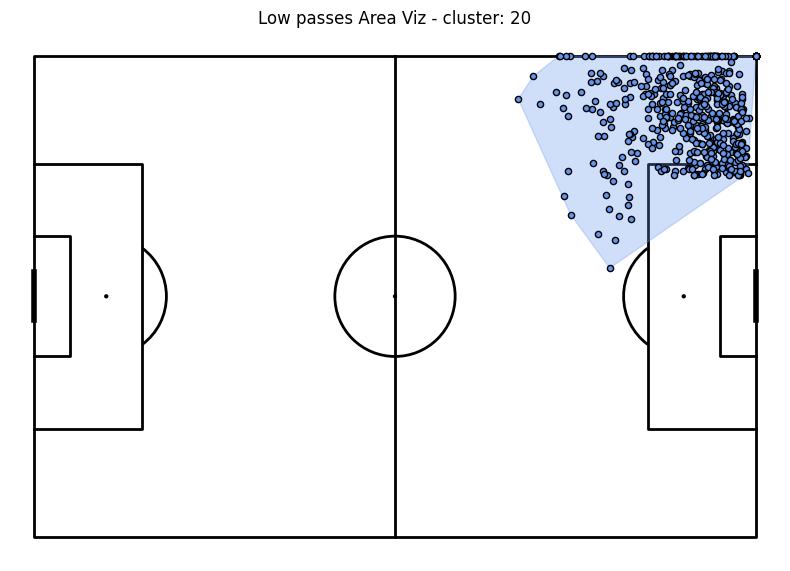

In [39]:
for cluster in range(1,4):
    area_clustered(data_low,tb_agg_low,cluster,'Low')

## Areas cluster with destiny

For High and low passes

In [40]:
# Roots passes starting there
def is_in_poly(row, poly):
    return poly[0]._path.contains_point((row['location_x'], row['location_y']))

In [41]:
def area_clustered_destiny(df,df_agg,top_clust,kmodel,scaler,ind_pass,season_year):
    best = df_agg['cluster'][top_clust-1]
    best_cluster = df[df['cluster'] == best]
    best_cluster = best_cluster[best_cluster['pass_outcome'] == 'Complete']
    x_c = scaler.inverse_transform([kmodel.cluster_centers_[best]])[0][0]
    y_c = scaler.inverse_transform([kmodel.cluster_centers_[best]])[0][1]
    x_end_c = scaler.inverse_transform([kmodel.cluster_centers_[best]])[0][2]
    y_end_c = scaler.inverse_transform([kmodel.cluster_centers_[best]])[0][3]
    
    # Number of nearest neighbors you want to find (in this case, 75%)
    num_neighbors = int(1 * len(best_cluster))
    
    # Initialize the nearest neighbors model with the desired number of neighbors
    knn = NearestNeighbors(n_neighbors=num_neighbors, algorithm='ball_tree')
    knn.fit(best_cluster[['location_x', 'location_y']])
    
    # Find the indices and distances of the nearest points to the reference point
    distances, indices = knn.kneighbors([(x_c, y_c)])
    
    # Get the points close to the reference point
    nearest_points_start = best_cluster.iloc[indices[0]]
    
    # Find the indices and distances of the nearest points to the reference point
    distances_end, indices_end = knn.kneighbors([(x_end_c, y_end_c)])
    
    # Get the points close to the reference point
    nearest_points_end = best_cluster.iloc[indices_end[0]]
    
    # Visualization
    pitch = Pitch(pitch_type='statsbomb',pitch_color='w', line_color='k')
    fig, ax = pitch.draw(figsize=(8, 6))
    fig.set_facecolor('w')
    narrow_hull = pitch.convexhull(nearest_points_start['location_x'], nearest_points_start['location_y'])
    narrow_poly = pitch.polygon(narrow_hull, ax=ax, edgecolor='cornflowerblue', facecolor='cornflowerblue', alpha=0.45)
    scatter = pitch.scatter(nearest_points_start['location_x'], nearest_points_start['location_y'], ax=ax, edgecolor='black', facecolor='cornflowerblue', s = 20)
    narrow_hull_end = pitch.convexhull(nearest_points_end['location_x_destiny'], nearest_points_end['location_y_destiny'])
    narrow_poly_end = pitch.polygon(narrow_hull_end, ax=ax, edgecolor='#c96059', facecolor='#c96059', alpha=0.45)
    scatter = pitch.scatter(nearest_points_end['location_x_destiny'], nearest_points_end['location_y_destiny'], ax=ax, edgecolor='black', facecolor='#c96059', s = 20)
    pitch.arrows(x_c, y_c, x_end_c, y_end_c, ax = ax, color = '#233628', edgecolor ='k');
    plt.title('Cluster Top ' + str(top_clust) + ' | Start and end locations - ' + ind_pass + ' passes', color = 'k')
    
    roots = data_low[data_low['team'] == 'Oakland Roots SC']
    roots = roots[roots['season'] == season_year]
    ddf = dd.from_pandas(roots, npartitions=10)
    ddf['in_poly'] = ddf.apply(is_in_poly, axis = 1, args = (narrow_poly,))
    roots = ddf.compute()
    best_cluster_opportunity = roots[roots['in_poly']]
    diff = best_cluster_opportunity['payoff'].mean() - data_low[data_low['cluster'] == best]['payoff'].mean()
    print(f'{diff} per pass')
    print(f'{diff * len(best_cluster_opportunity)} in total')
    
    most_frequent_route = best_cluster_opportunity['cluster'].value_counts().index[0]
    x_c_ = scaler.inverse_transform([kmodel.cluster_centers_[most_frequent_route]])[0][0]
    y_c_ = scaler.inverse_transform([kmodel.cluster_centers_[most_frequent_route]])[0][1]
    x_end_c_ = scaler.inverse_transform([kmodel.cluster_centers_[most_frequent_route]])[0][2]
    y_end_c_ = scaler.inverse_transform([kmodel.cluster_centers_[most_frequent_route]])[0][3]
    
    most_frequent = df[(df['cluster'] == most_frequent_route) & (df['pass_outcome'] == 'Complete')]
    # Number of nearest neighbors you want to find (in this case, 75%)
    num_neighbors_ = int(1 * len(most_frequent))
    
    # Initialize the nearest neighbors model with the desired number of neighbors
    knn_ = NearestNeighbors(n_neighbors=num_neighbors_, algorithm='ball_tree')
    knn_.fit(most_frequent[['location_x', 'location_y']])
    
    # Find the indices and distances of the nearest points to the reference point
    distances_end_, indices_end_ = knn_.kneighbors([(x_end_c_, y_end_c_)])
    
    # Get the points close to the reference point
    nearest_points_end_ = most_frequent.iloc[indices_end_[0]]
    narrow_hull_end_ = pitch.convexhull(nearest_points_end_['location_x_destiny'], nearest_points_end_['location_y_destiny'])
    pitch.polygon(narrow_hull_end_, ax=ax, edgecolor='#ede76d', facecolor='#ede76d', alpha=0.85)
    pitch.arrows(x_c, y_c, x_end_c_, y_end_c_, ax = ax, color = '#233628', edgecolor ='k');
    plt.show()

### High Passes

Top 3 for High Passes

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


0.05135756508364394 per pass
3.6977446860223635 in total


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


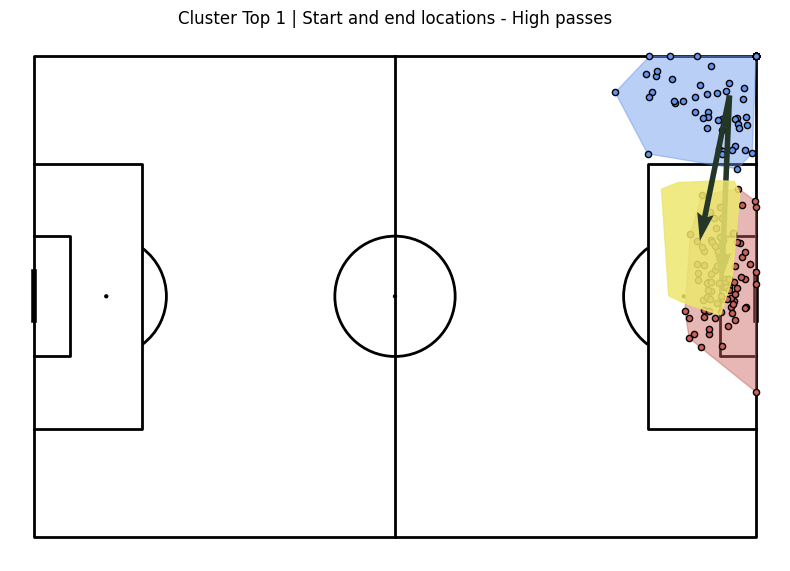

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


0.033814305702058796 per pass
11.699749772912343 in total


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


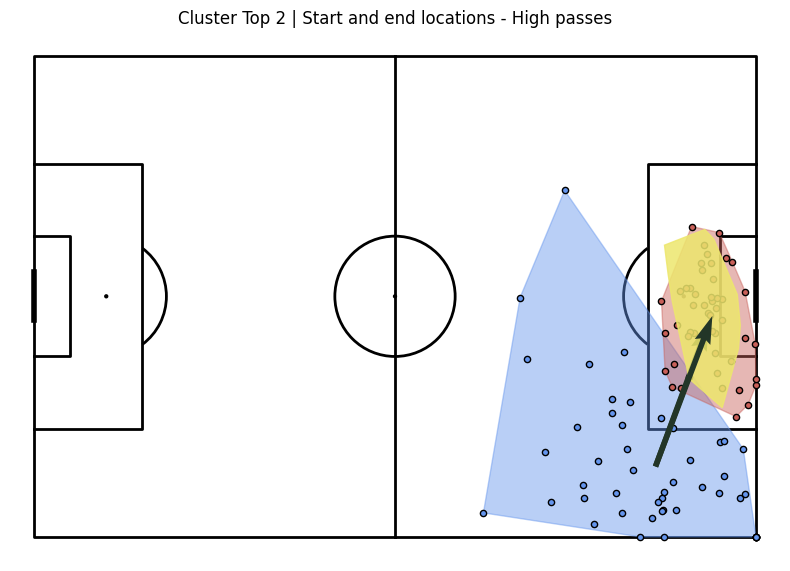

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


0.06099468119290749 per pass
14.882702211069427 in total


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


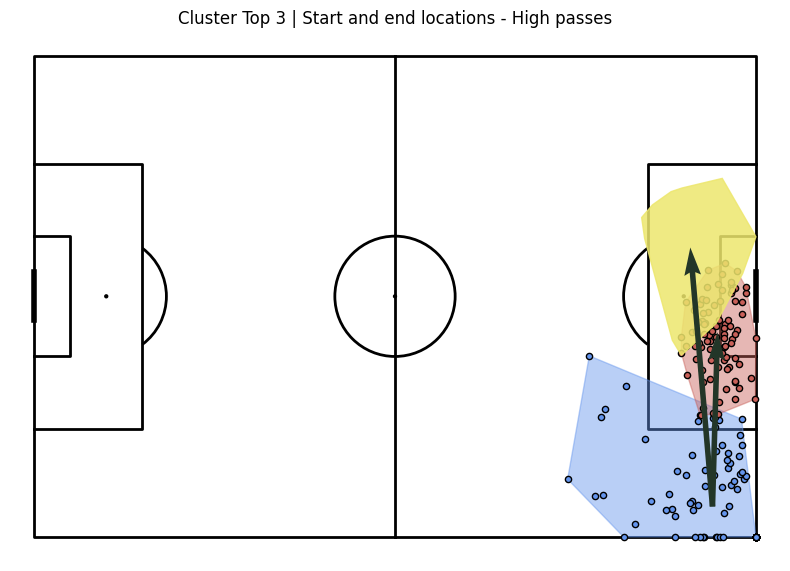

In [42]:
for cluster in range(1,4):
    area_clustered_destiny(data_high,tb_agg_high,cluster,kmeans_high,scaler_low,'High',2023)

### Low Passes

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


-0.05958320575716568 per pass
-8.28206560024603 in total


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


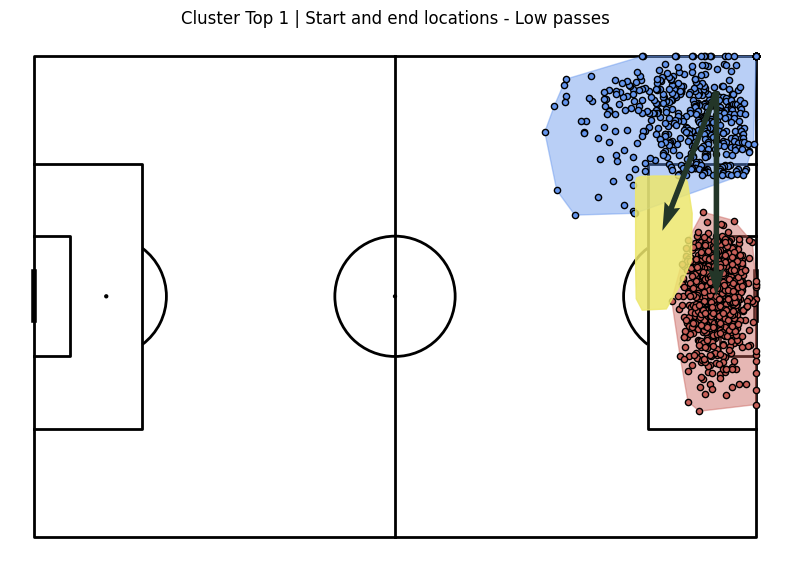

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


-0.043063090817601846 per pass
-13.866315243267794 in total


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


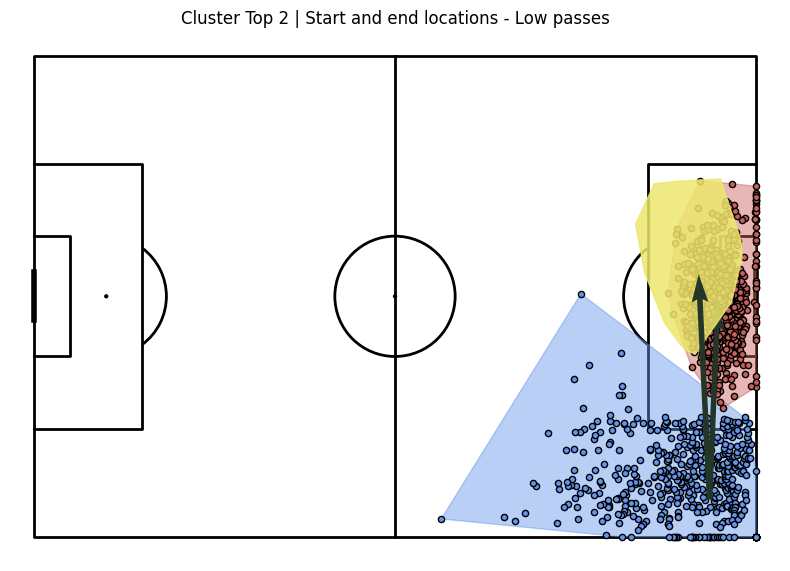

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


-0.04127449820689566 per pass
-6.851566702344679 in total


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


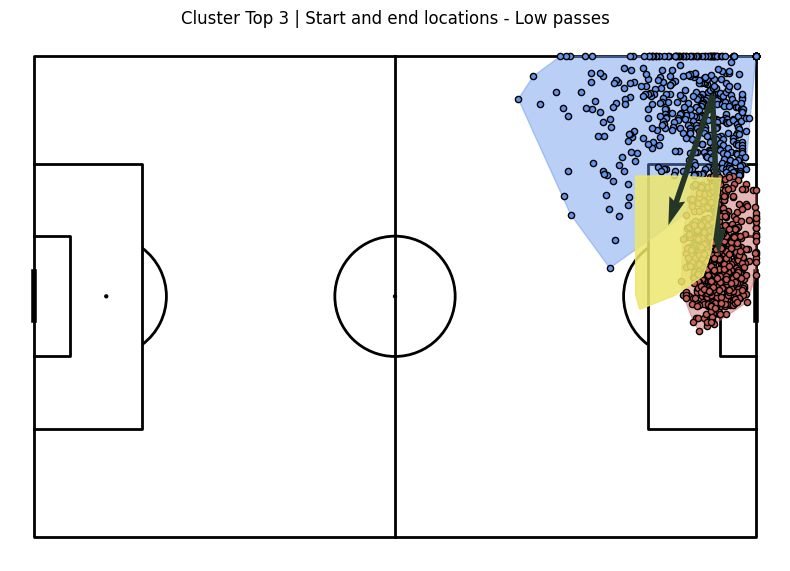

In [43]:
for cluster in range(1,4):
    area_clustered_destiny(data_low,tb_agg_low,cluster,kmeans_low,scaler_low,'Low',2023)

## Calculate xT metrics

Calculate xT metrics:
 - total_xT
 - avg_xT
 - atempts
 - succes_rate

And add if the pass was:
 - Left
 - Right
 - Center

In [44]:
def get_channel(row):
  if row['location_y'] <= 27:
    return 'left'
  elif row['location_y'] >= 53:
    return 'right'
  else:
    return 'center'

In [45]:
def xT_metrics(data):
    bu = data[data['location_x'] <= 120/3]
    bu['channel'] = bu.apply(get_channel, axis = 1)
    bu_agg = bu.groupby(['team', 'channel']).agg(
        total_xT=('xT_net', 'sum'),
        avg_xT=('xT_net', 'mean'),
        attempts=('xT_net', 'count'),
        success_rate=('pass_outcome_num', 'mean')).reset_index()
    return bu_agg

In [46]:
data_high_bu_agg = xT_metrics(data_high)
data_low_bu_agg  = xT_metrics(data_low)

In [47]:
data_high_bu_agg.sort_values(['avg_xT'], ascending = False).head(10)

team channel  total_xT    avg_xT  attempts  success_rate
35          Phoenix Rising  center  0.110363  0.110363         1           1.0
30        Oakland Roots SC    left  0.110041  0.110041         1           1.0
0        Birmingham Legion  center  0.188725  0.094363         2           1.0
21                Miami FC  center  0.171392  0.085696         2           1.0
17         Louisville City  center  0.167587  0.083793         2           1.0
50       Tampa Bay Rowdies  center  0.165776  0.082888         2           1.0
37  Pittsburgh Riverhounds  center  0.164188  0.082094         2           1.0
11       Hartford Athletic    left  0.161843  0.080922         2           1.0
48         San Diego Loyal    left  0.075291  0.075291         1           1.0
38  Pittsburgh Riverhounds    left  0.149995  0.074997         2           1.0

In [48]:
data_low_bu_agg.sort_values(['avg_xT'], ascending = False).head(10)

team channel  total_xT    avg_xT  attempts  success_rate
12      El Paso Locomotive  center  1.078193  0.119799         9      0.888889
23             Indy Eleven   right  0.455990  0.113997         4      0.750000
66         San Diego Loyal  center  1.125812  0.112581        10      1.000000
58       Rio Grande Valley    left  0.966656  0.107406         9      1.000000
61     Sacramento Republic    left  0.212714  0.106357         2      1.000000
54  Pittsburgh Riverhounds  center  0.838532  0.104817         8      1.000000
37                Miami FC    left  0.835219  0.104402         8      1.000000
49        Orange County SC    left  0.982628  0.098263        10      0.900000
19       Hartford Athletic    left  0.471804  0.094361         5      1.000000
69       Tampa Bay Rowdies  center  0.369806  0.092452         4      1.000000

### By pass Cluster

In [49]:
def xT_metrics_cluster(data):
    bu = data[data['location_x'] <= 120/3]
    bu['channel'] = bu.apply(get_channel, axis = 1)
    bu_agg = bu.groupby(['team', 'channel','cluster']).agg(
        total_xT=('xT_net', 'sum'),
        avg_xT=('xT_net', 'mean'),
        attempts=('xT_net', 'count'),
        success_rate=('pass_outcome_num', 'mean')).reset_index()
    return bu_agg

In [50]:
data_high_bu_agg_clus = xT_metrics_cluster(data_high)
data_low_bu_agg_clus  = xT_metrics_cluster(data_low)

Top 5 per cluster for High

In [51]:
grouped = data_high_bu_agg_clus[data_high_bu_agg_clus.cluster != -1].groupby('cluster')

# Calculate dense rank of 'avg_xT' within each group
data_high_bu_agg_clus['ranked'] = grouped['avg_xT'].transform(lambda x: x.rank(ascending=False, method='dense'))

data_high_bu_agg_clus[data_high_bu_agg_clus['ranked'] <= 5].drop('ranked', axis=1).sort_values(['cluster','avg_xT'])

team channel  cluster  total_xT    avg_xT  attempts  \
47  Pittsburgh Riverhounds  center        4  0.063961  0.063961         1   
65       Tampa Bay Rowdies  center        4  0.165776  0.082888         2   
13             Indy Eleven  center        4  0.097832  0.097832         1   
20         Louisville City  center        4  0.107267  0.107267         1   
45          Phoenix Rising  center        4  0.110363  0.110363         1   
62         San Diego Loyal    left        9  0.075291  0.075291         1   
11       Hartford Athletic    left        9  0.161843  0.080922         2   
0        Birmingham Legion  center        9  0.188725  0.094363         2   
48  Pittsburgh Riverhounds  center        9  0.100227  0.100227         1   
36       New Mexico United    left        9  0.202149  0.101074         2   
34       New Mexico United  center       18 -0.002745 -0.002745         1   
39        Oakland Roots SC    left       18  0.110041  0.110041         1   
38        Oakland Roots SC  center       20  0.058213  0.058213         1   
26                Miami FC  center       20  0.097736  0.097736         1   
19        Las Vegas Lights   right       20  0.106364  0.106364         1   

    success_rate  
47           1.0  
65           1.0  
13           1.0  
20           1.0  
45           1.0  
62           1.0  
11           1.0  
0            1.0  
48           1.0  
36           1.0  
34           0.0  
39           1.0  
38           1.0  
26           1.0  
19           1.0

Top 5 cluster per Low

In [52]:
grouped = data_low_bu_agg_clus[data_low_bu_agg_clus.cluster != -1].groupby('cluster')

# Calculate dense rank of 'avg_xT' within each group
data_low_bu_agg_clus['ranked'] = grouped['avg_xT'].transform(lambda x: x.rank(ascending=False, method='dense'))

data_low_bu_agg_clus[data_low_bu_agg_clus['ranked'] <= 5].drop('ranked', axis=1).sort_values(['cluster','avg_xT'])

team channel  cluster  total_xT    avg_xT  attempts  \
35       El Paso Locomotive    left        3  0.272925  0.136462         2   
140       Rio Grande Valley  center        3  0.283025  0.141513         2   
171       Tampa Bay Rowdies   right        3  0.285777  0.142888         2   
31       El Paso Locomotive  center        3  0.168244  0.168244         1   
57              Indy Eleven   right        3  0.353356  0.353356         1   
1         Birmingham Legion  center        4  0.063197  0.063197         1   
172       Tampa Bay Rowdies   right        4  0.063461  0.063461         1   
23             Detroit City  center        4  0.063570  0.063570         1   
117        Orange County SC  center        4  0.063987  0.063987         1   
32       El Paso Locomotive  center        4  0.339666  0.339666         1   
24             Detroit City  center        8 -0.002469 -0.002469         1   
101       New Mexico United  center        8  0.061610  0.061610         1   
105       New Mexico United    left        8  0.131843  0.131843         1   
134  Pittsburgh Riverhounds  center       11  0.114230  0.114230         1   
149     Sacramento Republic    left       11  0.115122  0.115122         1   
91                 Miami FC    left       11  0.578712  0.115742         5   
121        Orange County SC    left       11  0.839578  0.119940         7   
25             Detroit City  center       11  0.454767  0.151589         3   
54              Indy Eleven  center       19  0.307111  0.102370         3   
46        Hartford Athletic  center       19  0.419506  0.104877         4   
161         San Diego Loyal  center       19  0.107830  0.107830         1   
119        Orange County SC  center       19  0.110051  0.110051         1   
61         Las Vegas Lights  center       19  0.233437  0.116719         2   
4         Birmingham Legion  center       24  0.044047  0.044047         1   
85              Memphis 901   right       24  0.044812  0.044812         1   
136  Pittsburgh Riverhounds  center       24  0.059577  0.059577         1   

     success_rate  
35            1.0  
140           1.0  
171           1.0  
31            1.0  
57            1.0  
1             1.0  
172           1.0  
23            1.0  
117           1.0  
32            1.0  
24            0.0  
101           1.0  
105           1.0  
134           1.0  
149           1.0  
91            1.0  
121           1.0  
25            1.0  
54            1.0  
46            1.0  
161           1.0  
119           1.0  
61            1.0  
4             1.0  
85            1.0  
136           1.0

## Grouped by OR

Grouped top

In [53]:
def grouped(df, by):
  result_sorted = df.sort_values(by=['channel', by], ascending=[True, False])
  result_sorted['rank'] = result_sorted.groupby('channel').cumcount() + 1
  return result_sorted[result_sorted['team'] == 'Oakland Roots SC' ][['team', 'channel', by, 'rank']]

High Passes

In [54]:
print(grouped(data_high_bu_agg_clus, 'total_xT'))
print(grouped(data_high_bu_agg_clus, 'avg_xT'))
print(grouped(data_high_bu_agg_clus, 'attempts'))
print(grouped(data_high_bu_agg_clus, 'success_rate'))

                team channel  total_xT  rank
38  Oakland Roots SC  center  0.058213    13
39  Oakland Roots SC    left  0.110041     4
40  Oakland Roots SC   right  0.041694     8
                team channel    avg_xT  rank
38  Oakland Roots SC  center  0.058213    12
39  Oakland Roots SC    left  0.110041     1
40  Oakland Roots SC   right  0.041694     5
                team channel  attempts  rank
38  Oakland Roots SC  center         1    22
39  Oakland Roots SC    left         1    14
40  Oakland Roots SC   right         1    15
                team channel  success_rate  rank
38  Oakland Roots SC  center           1.0    10
39  Oakland Roots SC    left           1.0     3
40  Oakland Roots SC   right           1.0     2


Low Passes

In [55]:
print(grouped(data_low_bu_agg_clus, 'total_xT'))
print(grouped(data_low_bu_agg_clus, 'avg_xT'))
print(grouped(data_low_bu_agg_clus, 'attempts'))
print(grouped(data_low_bu_agg_clus, 'success_rate'))

                 team channel  total_xT  rank
110  Oakland Roots SC  center  0.305984    15
111  Oakland Roots SC  center  0.041820    69
113  Oakland Roots SC    left  0.142002    20
112  Oakland Roots SC    left  0.035872    43
115  Oakland Roots SC   right  0.152779    20
114  Oakland Roots SC   right -0.002480    54
                 team channel    avg_xT  rank
110  Oakland Roots SC  center  0.101995    15
111  Oakland Roots SC  center  0.041820    64
113  Oakland Roots SC    left  0.071001    21
112  Oakland Roots SC    left  0.035872    42
115  Oakland Roots SC   right  0.038195    44
114  Oakland Roots SC   right -0.002480    54
                 team channel  attempts  rank
110  Oakland Roots SC  center         3    34
111  Oakland Roots SC  center         1    65
113  Oakland Roots SC    left         2    25
112  Oakland Roots SC    left         1    38
115  Oakland Roots SC   right         4     9
114  Oakland Roots SC   right         1    48
                 team channel  suc

Grouped with cluster

Gruoped top

In [56]:
def grouped_clus(df, by):
    df = df[df.cluster != -1]
    result_sorted = df.sort_values(by=['channel', by, 'cluster'], ascending=[True, False, True])
    result_sorted['rank'] = result_sorted.groupby(['channel','cluster']).cumcount() + 1
    return result_sorted[result_sorted['team'] == 'Oakland Roots SC' ][['team', 'channel', by, 'cluster','rank']]

High Passes

In [57]:
print(grouped_clus(data_high_bu_agg_clus, 'total_xT'))
print(grouped_clus(data_high_bu_agg_clus, 'avg_xT'))
print(grouped_clus(data_high_bu_agg_clus, 'attempts'))
print(grouped_clus(data_high_bu_agg_clus, 'success_rate'))

                team channel  total_xT  cluster  rank
38  Oakland Roots SC  center  0.058213       20     2
39  Oakland Roots SC    left  0.110041       18     1
40  Oakland Roots SC   right  0.041694        4     7
                team channel    avg_xT  cluster  rank
38  Oakland Roots SC  center  0.058213       20     2
39  Oakland Roots SC    left  0.110041       18     1
40  Oakland Roots SC   right  0.041694        4     4
                team channel  attempts  cluster  rank
38  Oakland Roots SC  center         1       20     2
39  Oakland Roots SC    left         1       18     1
40  Oakland Roots SC   right         1        4    13
                team channel  success_rate  cluster  rank
38  Oakland Roots SC  center           1.0       20     2
39  Oakland Roots SC    left           1.0       18     1
40  Oakland Roots SC   right           1.0        4     1


Low Passes

In [58]:
print(grouped_clus(data_low_bu_agg_clus, 'total_xT'))
print(grouped_clus(data_low_bu_agg_clus, 'avg_xT'))
print(grouped_clus(data_low_bu_agg_clus, 'attempts'))
print(grouped_clus(data_low_bu_agg_clus, 'success_rate'))

                 team channel  total_xT  cluster  rank
110  Oakland Roots SC  center  0.305984       11     8
111  Oakland Roots SC  center  0.041820       19    23
113  Oakland Roots SC    left  0.142002       11    15
112  Oakland Roots SC    left  0.035872        3    11
115  Oakland Roots SC   right  0.152779       19    13
114  Oakland Roots SC   right -0.002480        3    17
                 team channel    avg_xT  cluster  rank
110  Oakland Roots SC  center  0.101995       11     5
111  Oakland Roots SC  center  0.041820       19    20
113  Oakland Roots SC    left  0.071001       11     9
112  Oakland Roots SC    left  0.035872        3    11
115  Oakland Roots SC   right  0.038195       19    19
114  Oakland Roots SC   right -0.002480        3    17
                 team channel  attempts  cluster  rank
110  Oakland Roots SC  center         3       11    15
111  Oakland Roots SC  center         1       19    19
113  Oakland Roots SC    left         2       11    21
112  Oakla